In [8]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [2]:
# Prepare data file location and name
data_file_location = "..//Jupyter//data//processed//"
data_file_name_train = "apple_stock_price_processed_train"
data_file_name_validate = "apple_stock_price_processed_validate"
data_file_name_test = "apple_stock_price_processed_test"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [3]:
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (2923, 6)
Validation Dataset Shape: (124, 6)
Testing Dataset Shape: (139, 6)


In [4]:
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close        Date
0  0.065924  0.073021  0.056607  0.056249   0.056249  2012-05-18
1  0.050743  0.050238  0.042767  0.044725   0.044725  2012-05-21
2  0.039961  0.041851  0.037065  0.036411   0.036411  2012-05-22
3  0.036551  0.038873  0.038227  0.039155   0.039155  2012-05-23
4  0.040897  0.040813  0.039362  0.041981   0.041981  2012-05-24
Validation Dataset:
       Open      High       Low     Close  Adj Close        Date
0  0.916502  0.914850  0.892598  0.901523   0.901523  2024-01-02
1  0.899065  0.900617  0.901373  0.896529   0.896529  2024-01-03
2  0.897745  0.901164  0.901982  0.903800   0.903800  2024-01-04
3  0.904593  0.915779  0.909899  0.917053   0.917053  2024-01-05
4  0.925798  0.930749  0.925926  0.935464   0.935465  2024-01-08
Testing Dataset:
       Open      High       Low     Close  Adj Close        Date
0  1.339026  1.333962  1.316559  1.336123   1.338969  2024-07-01
1  1.327503  1.344670  1.333942  1.

In [5]:
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [6]:
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close']

scaler = MinMaxScaler()
scaler.fit(data_train_df[features])  # fit only on training data

data_train_scaled = scaler.transform(data_train_df[features])
data_validate_scaled = scaler.transform(data_validate_df[features])
data_test_scaled = scaler.transform(data_test_df[features])

In [10]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [11]:
sequence_size = 60
target_index = 3  # predicting 'Close'
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, target_index)
X_val, y_val = construct_lstm_data(data_validate_scaled, sequence_size, target_index)
X_test, y_test = construct_lstm_data(data_test_scaled, sequence_size, target_index)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (2863, 60, 5)
y_train shape: (2863,)


In [12]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [13]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (3186, 5)

 Data Train Scaled: (2923, 5)
> Data Train X: (2863, 60, 5)
> Data Train y: (2863,)

 Data Validate Scaled: (124, 5)
> Data Validate X: (124, 60, 5)
> Data Validate y: (124,)

 Data Test Scaled: (139, 5)
> Data Test X: (139, 60, 5)
> Data Test y: (139,)


In [14]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units = 100))
model.add(Dropout(rate = 0.2))
model.add(Dense(units=1))

In [17]:
#optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer = "adam", loss="mse")

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_location = "..//Jupyter//models//"
model_name = "apple_stock_price_lstm.model.keras"

# Save the best model based on validation loss
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=1
)

# Stop training if validation loss doesn't improve for 10 epochs
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=1,
    restore_best_weights=True
)

# Reduce learning rate if validation loss plateaus for 5 epochs
reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,   # reduce LR by half
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

callbacks = [best_model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [21]:
history = model.fit(
    x = X_train, 
    y = y_train, 
    validation_data=(X_validate, y_validate),
    validation_split = 0.1,
    epochs=100, 
    batch_size = 64, 
    callbacks = [best_model_checkpoint_callback, early_stopping_callback, reduce_lr_callback] )

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0012
Epoch 1: val_loss did not improve from 0.00290
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0012 - val_loss: 0.0066 - learning_rate: 2.5000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0011
Epoch 2: val_loss did not improve from 0.00290
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0011 - val_loss: 0.0055 - learning_rate: 2.5000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0013
Epoch 3: val_loss did not improve from 0.00290
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0013 - val_loss: 0.0063 - learning_rate: 2.5000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0013
Epoch 4: val_loss did not improve from 0.00290
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0013 - val_loss: 0.0070 - learning_rate: 2.5000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0012
Epoch 5: val_loss did not improve from 0.00290
45/45 ━━━━━━━

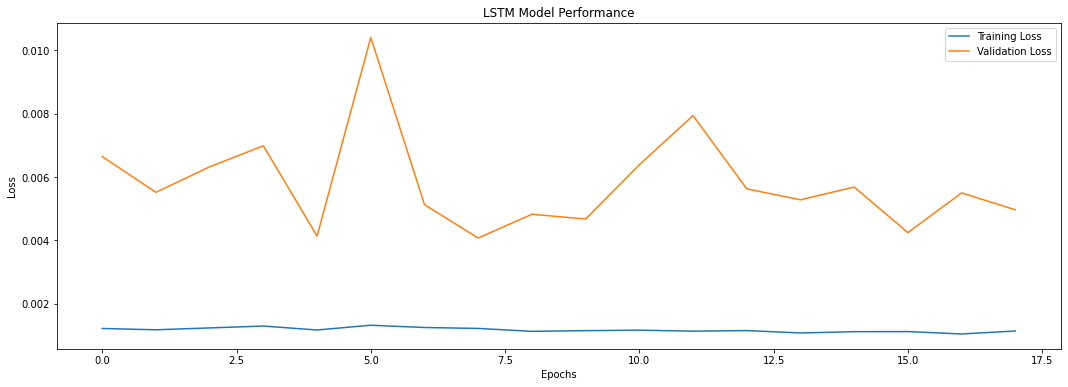

In [22]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
corr = data.corr()

NameError: name 'data' is not defined

In [23]:
# Prepare model location and name
model_location = "..//Jupyter//models//"
model_name = "apple_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

In [24]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [25]:
# Prepare scaler model name and location
scaler_model_location = "..//Jupyter//models//"
scaler_model_name = "apple_stock_price_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

In [26]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 4))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 4))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 4))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 4))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict),4))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 4))), axis=1))[:,0]

In [27]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

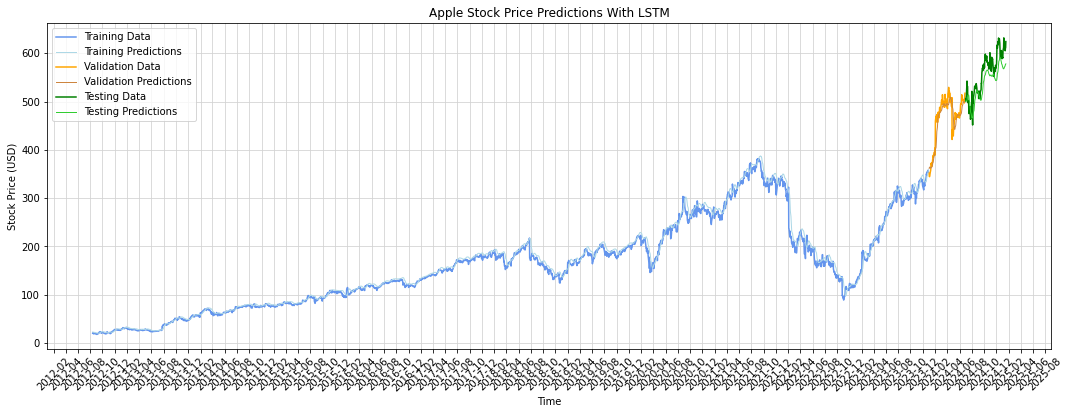

In [28]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Apple Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

In [25]:
from sklearn.metrics import r2_score


r2_train = r2_score(y_train_inv, y_train_predict_inv)
r2_val = r2_score(y_validate_inv, y_validate_predict_inv)
r2_test = r2_score(y_test_inv, y_test_predict_inv)

print(f"R² (Train): {r2_train:.4f}")
print(f"R² (Validation): {r2_val:.4f}")
print(f"R² (Test): {r2_test:.4f}")

R² (Train): 0.9898
R² (Validation): 0.8744
R² (Test): 0.7156
